## Question 1  
NO, if the weights of all variable is the same. Backpropagation will yield the same results and all of the neuron will have the same weights. This lead to the symmetry of the model and it will behave like one neuron model.

## Question 2  
Yes, bias terms can be initialized as zero.

## Question 3. 
1. SELU can perform self normalization of the input and output. This behavior can mitigate vanishing gradient and exploding gradient.  
2. SELU can be differentiate if z < 0. This, also, can mitigate vanishing gradient.  
3. SELU can also differentiate at z = 0. This property make SELU more stable in converging to global optimal.  
4. It always has a non-zero derivative, which avoids dying units.

## Question 4. 
1. SELU can do self normalization if the model is dense, it also can be diff if z<=0. Thus it is preferable on general case.  
2. Leaky ReLU is the improve ment on ReLU in the way that it can be diff if z < 0. Thus it can mitigate vanishing gradient. However, this introduced one more parameter to be tweaked which is alpha.  
3. ReLU in practice give the model good performance and it very fast to compute. Thus, if you want to speed things up with reasonable performance, ReLU is a good choice.  
4. Tanh and logistic shouldn't be used in hidden layer, since it is saturated acitvation func. It will introduce vanishing gradient. But it can be used at the output layer for classification task.  
5. Softmax will be used at output layer for multilabel classification tasks.

## Question 5  
If we set the momentum too close to 1. The algorithm will quickly pick up a lot of speed (assume it is negative for now), then it shoot right pass the global optimum. After passing the global optimum, the speed will slowdown (because the current gradient is positive at cancel out the accumulate negative gradient) and comeback. It will osscilate this way before converging. 

## Question 6. 
* To produce sparse model, we have to implement l1 normalization which eliminate the unnecessary weights.  
* The other way is to implement tf Model Optimization Toolkit.

## Question 7. 
* Dropout slows down training phase, because it randomly eliminate the neuron in each steps and make the model harder to fit to the given data. However, at testing phase, the dropout will be cancel out. So it is not slowdown testing at all.  
* MC dropout slows down train phase as well as typical dropout. It also slows down testing phase, since the concept of MC is to testing multiple time while dropout is still on. The final results will be averaged from multiple testing.

## Question 8. 

**Test the knowledge in this chapter on CIFAR10 image**

In [1]:
import tensorflow.keras.datasets as tfds

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train, y_train) , (X_test, y_test) = tfds.cifar10.load_data()

170500096/170498071 [==============================] - 27s 0us/step


In [98]:
print(X_train.shape)
print(X_train.max())
print(y_train.max())
print(y_train.min())
print(y_train.dtype)

(50000, 32, 32, 3)
255
9
0
uint8


In [63]:
X_train_scale = X_train/255.
X_test_scale = X_test/255.

print(X_train_scale.dtype)
print(X_train_scale.max())

float64
1.0


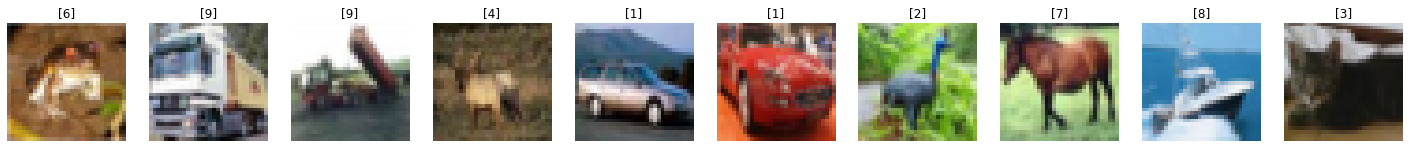

In [28]:
import matplotlib.pyplot as plt

num_show = 10
n_rows = 5
n_columns = num_show
scale = 5
figure = plt.figure(figsize = (n_rows*scale, n_columns*scale))

for i in range(num_show):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(X_train[i])
    plt.title(f'{y_train[i]}')
    plt.axis('Off')

In [100]:
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [76]:
tf.keras.backend.clear_session()

models = Sequential(
    [
        Input(shape=[32, 32, 3]),
        Flatten()
    ] +
    [Dense(100, activation = 'elu', kernel_initializer = 'he_normal') for i in range(20)] +
    [
        Dense(10, activation = 'softmax', kernel_initializer = 'he_normal')
    ]
)
models.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=tf.optimizers.Nadam())

In [77]:
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [78]:
import os
import sys

SAVE_PATH = './saved_model/ch11-train-dnn'
MODEL_NAME = 'dnn-cifar10'

os.makedirs(SAVE_PATH, exist_ok = True)
MODEL_FP = os.path.join(SAVE_PATH, MODEL_NAME)

print(sys.version)
print(tf.__version__)

3.7.9 (v3.7.9:13c94747c7, Aug 15 2020, 01:31:08) 
[Clang 6.0 (clang-600.0.57)]
2.3.0


### Implement various of callbacks

In [131]:
## create callbacks

early_cb = tf.keras.callbacks.EarlyStopping(patience=10)
savebest_cb = tf.keras.callbacks.ModelCheckpoint(MODEL_FP, save_best_only=True)

In [80]:
def lr_shceduler_gen(step, scale):
    
    def lr_shceduler(epoch, lr):
        return lr*scale**(1/step)
    
    return lr_shceduler

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(lr_shceduler_gen(20, 10))

In [83]:
K = tf.keras.backend

class LRSchdulerOnBatchEnd(tf.keras.callbacks.Callback):
    def __init__(self, step, scale):
        self.step = step
        self.scale = scale
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.scale**(1/self.step))
        
lr_schedule_cb = LRSchdulerOnBatchEnd(10, 1.005)

In [84]:
## find the optimal lr first

history = models.fit(X_train_scale, y_train, epochs = 10, callbacks = [lr_schedule_cb])

Epoch 1/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.1305 - accuracy: 0.21760s - loss: 2.1310 - accuracy: 
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 2.9829 - accuracy: 0.1832
Epoch 3/10
1563/1563 [==============================] - 21s 13ms/step - loss: 2.3346 - accuracy: 0.0999
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 14231978115072.0000 - accuracy: 0.0993
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 2.5466 - accuracy: 0.1002
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 3.2024 - accuracy: 0.1016
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 4.6024 - accuracy: 0.1013
Epoch 8/10
1563/1563 [==============================] - 22s 14ms/step - loss: 5.3750 - accuracy: 0.1010
Epoch 9/10
1563/1563 [==============================] - 27s 17ms/step - loss: 7.9590 - accuracy: 0.0969
Epoch 10/10
1563/1563

0.0022300333


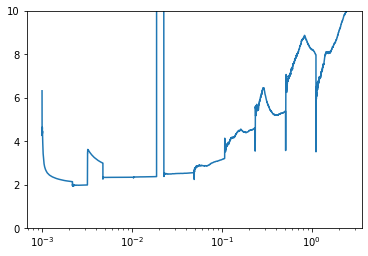

In [94]:
import numpy as np

plt.plot(lr_schedule_cb.rates, lr_schedule_cb.losses)
plt.ylim([0,10])
plt.gca().set_xscale('log')

losses_min_pos = np.argmin(lr_schedule_cb.losses)
print(lr_schedule_cb.rates[losses_min_pos])

In [117]:
tf.keras.backend.clear_session()

In [132]:
## Times to train with specific learning rate
tf.keras.backend.clear_session()

true_model = Sequential(
    [
        Input(shape=[32, 32, 3]),
        Flatten()
    ] +
    [Dense(100, activation = 'elu', kernel_initializer = 'he_normal') for i in range(20)] +
    [
        Dense(10, activation = 'softmax', kernel_initializer = 'he_normal')
    ]
)
true_model.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], 
                   optimizer=tf.optimizers.Nadam())

In [133]:
true_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [134]:
print(y_train.dtype)
print(y_test.dtype)

uint8
uint8


In [135]:
history = true_model.fit(X_train_scale, y_train, 
                     epochs = 100, callbacks = [early_cb, savebest_cb],
                     validation_data=(X_test_scale, y_test)
                    )

Epoch 1/100
1563/1563 [==============================] - 33s 21ms/step - loss: 2.0698 - accuracy: 0.2479 - val_loss: 1.9097 - val_accuracy: 0.3092
Epoch 2/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.8437 - accuracy: 0.3270 - val_loss: 1.7952 - val_accuracy: 0.3478
Epoch 3/100
1563/1563 [==============================] - 36s 23ms/step - loss: 1.7766 - accuracy: 0.3603 - val_loss: 1.7019 - val_accuracy: 0.3890
Epoch 4/100
1563/1563 [==============================] - 21s 13ms/step - loss: 1.7218 - accuracy: 0.3802 - val_loss: 1.7260 - val_accuracy: 0.3801
Epoch 5/100
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6767 - accuracy: 0.3991 - val_loss: 1.7068 - val_accuracy: 0.3968
Epoch 6/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.6418 - accuracy: 0.4149 - val_loss: 1.6479 - val_accuracy: 0.4045
Epoch 7/100
1563/1563 [==============================] - 30s 19ms/step - loss: 1.6167 - accuracy: 0.4251 - val_loss: 1

In [138]:
model = tf.keras.models.load_model('./saved_model/ch11-train-dnn/dnn-cifar10')
true_model.evaluate(X_test_scale, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6401 - accuracy: 0.4168


[1.6400595903396606, 0.41679999232292175]

**We can cleary see that the model is very hard to train.**  
It takes o10 epochs for the training loss to be lower!  
Now, let's implement batch normalization

In [143]:
## Times to train with specific learning rate
tf.keras.backend.clear_session()

def gen_batch_dense(num_layers = 20):
    output = []
    
    for i in range(num_layers):
        output = output + [BatchNormalization(), Dense(100, activation = 'elu', kernel_initializer = 'he_normal')]
        
    return output

true_model = Sequential(
    [
        Input(shape=[32, 32, 3]),
        Flatten()
    ] +
    gen_batch_dense(num_layers = 20) +
    [
        Dense(10, activation = 'softmax', kernel_initializer = 'he_normal')
    ]
)
true_model.compile(loss = 'sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=tf.optimizers.Nadam())

In [144]:
true_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1

In [145]:
os.makedirs('./saved_model/ch11-train-dnn/dnn-bn-cifar10', exist_ok = True)

save_best_cb = tf.keras.callbacks.ModelCheckpoint('./saved_model/ch11-train-dnn/dnn-bn-cifar10')

In [146]:
history = true_model.fit(X_train_scale, y_train, 
                     epochs = 50, callbacks = [early_cb, savebest_cb],
                     validation_data=(X_test_scale, y_test)
                    )

Epoch 1/50
1563/1563 [==============================] - 34s 21ms/step - loss: 1.9049 - accuracy: 0.3150 - val_loss: 1.7173 - val_accuracy: 0.3870
Epoch 2/50
1563/1563 [==============================] - 33s 21ms/step - loss: 1.7128 - accuracy: 0.3880 - val_loss: 1.5870 - val_accuracy: 0.4442
Epoch 3/50
1563/1563 [==============================] - 45s 29ms/step - loss: 1.6372 - accuracy: 0.4204 - val_loss: 1.5414 - val_accuracy: 0.4527
Epoch 4/50
1563/1563 [==============================] - 46s 29ms/step - loss: 1.5794 - accuracy: 0.4420 - val_loss: 1.5028 - val_accuracy: 0.4610
Epoch 5/50
1563/1563 [==============================] - 44s 28ms/step - loss: 1.5447 - accuracy: 0.4503 - val_loss: 1.4718 - val_accuracy: 0.4825
Epoch 6/50
1563/1563 [==============================] - 46s 29ms/step - loss: 1.4999 - accuracy: 0.4706 - val_loss: 1.4437 - val_accuracy: 0.4901
Epoch 7/50
1563/1563 [==============================] - 35s 23ms/step - loss: 1.4700 - accuracy: 0.4819 - val_loss: 1.4482 -

1563/1563 [==============================] - 31s 20ms/step - loss: 1.0194 - accuracy: 0.6438 - val_loss: 1.3342 - val_accuracy: 0.5419
Epoch 39/50
1563/1563 [==============================] - 31s 20ms/step - loss: 1.0082 - accuracy: 0.6474 - val_loss: 1.3416 - val_accuracy: 0.5378
Epoch 40/50
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0058 - accuracy: 0.6482 - val_loss: 1.3666 - val_accuracy: 0.5326
Epoch 41/50
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9991 - accuracy: 0.6515 - val_loss: 1.3548 - val_accuracy: 0.5451
Epoch 42/50
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9907 - accuracy: 0.6545 - val_loss: 1.3605 - val_accuracy: 0.5384
Epoch 43/50
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9822 - accuracy: 0.6563 - val_loss: 1.3772 - val_accuracy: 0.5333
Epoch 44/50
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9763 - accuracy: 0.6600 - val_loss: 1.3648 - val_

In [147]:
true_model.evaluate(X_test_scale, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.3984 - accuracy: 0.5338


[1.3984090089797974, 0.5338000059127808]